In [121]:
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import rasterio

from random import randrange

import xarray
import xrspatial.multispectral as ms

import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = '15'

In [122]:
DATA_DIR = Path.cwd().parent / "data/raw/train"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

BANDS = ["B02", "B03", "B04", "B08"]

In [123]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [124]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...,C:\Users\maxlu\Desktop\Machine_Learning\PROJEC...


## Define helping functions

In [125]:
def load_features(image_index):
    image = np.zeros((512,512,4))
    for i, band in enumerate(['B02_path', 'B03_path', 'B04_path', 'B08_path']):
        with rasterio.open(train_meta[band][image_index]) as img:            
            image[:,:,i] = img.read(1)
    return image

In [126]:
def load_label(image_index):
    image = np.zeros((512,512,1))
    with rasterio.open(train_meta['label_path'][image_index]) as img:            
        image[:,:,0] = img.read(1)
    return image

In [127]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(image_index):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    blue = get_xarray(train_meta['B02_path'][image_index])
    green = get_xarray(train_meta['B03_path'][image_index])
    red = get_xarray(train_meta['B04_path'][image_index])

    return ms.true_color(r=red, g=green, b=blue)

In [128]:
def cover_percentage(image_index):
    img = load_label(image_index)
    return np.sum(img)/(512*512)

## Calculate cloud cover distribution

In [129]:
train_meta['coud_cover'] = 0
for i in range(len(train_meta)):
    train_meta.iloc[i, -1] = cover_percentage(i)
    if(i%25 == 0):
        print(round(100*i/len(train_meta), 2), '%', end='\r')

In [130]:
train_meta['coud_cover'].describe()

count    11748.000000
mean         0.621644
std          0.376497
min          0.000000
25%          0.267097
50%          0.726723
75%          1.000000
max          1.000000
Name: coud_cover, dtype: float64

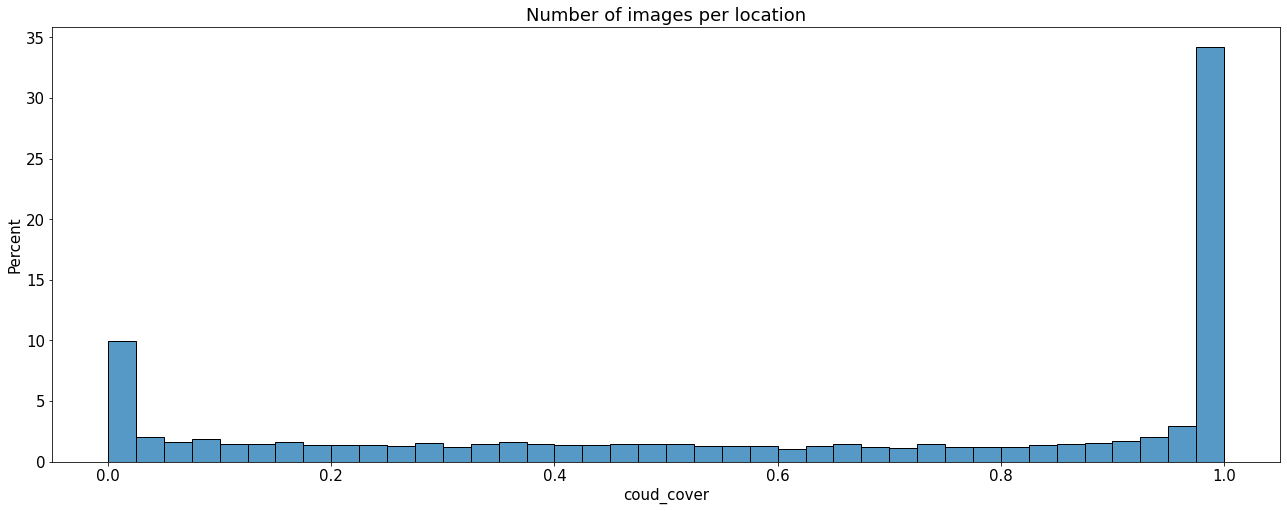

In [136]:
fig, ax = plt.subplots(1,1, figsize=(22,8))
sns.histplot(train_meta, x=train_meta.iloc[:,-1], ax=ax, bins=40, stat='percent')
ax.set_title('Number of images per location');